# Classifying Political Social Media Posts with Natural Language Processing

* Student name: Avonlea Fisher
* Student pace: full time
* Scheduled project review date/time: Tue, Nov 3, 2020, 02:00 PM - 02:45 PM
* Instructor name: James Irving
* Blog post URL: https://avfisher.medium.com/classifying-political-social-media-posts-with-natural-language-processing-5b92c9e3ac67


# Introduction

This project aims to create two classification models for political social media posts. The first will be a binary classifier to predict whether the posts are partisan or neutral. The second will be a multiclass model that predicts the overall message category of a post. We'll use the [Political Social Media Posts dataset](https://www.kaggle.com/crowdflower/political-social-media-posts) on Kaggle, which contains Facebook and Twitter posts from politicians' accounts, as well as human-labeled variables such as the post's bias and substance of its message. Posts were collected from the year 2015. The ability to classify the bias and message of politicians' posts can help constituents, political organizations, and research institutions better understand their political views. All dependencies for the project are imported below.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from nlp_primitives import LSA
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from collections import Counter
import tweepy
import re
import string
import imblearn
import joblib

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Exploring and Preprocessing the Data

Let's read in and preview the data:

In [2]:
df = pd.read_csv('political_social_media.csv', encoding='latin1')

In [3]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


In [4]:
df.shape

(5000, 21)

Now let's check for missing values in the columns of interest: bias and text.

In [5]:
df.isna().sum()

_unit_id                  0
_golden                   0
_unit_state               0
_trusted_judgments        0
_last_judgment_at         0
audience                  0
audience:confidence       0
bias                      0
bias:confidence           0
message                   0
message:confidence        0
orig__golden           5000
audience_gold          5000
bias_gold              5000
bioid                     0
embed                     0
id                        0
label                     0
message_gold           5000
source                    0
text                      0
dtype: int64

Fortunately, it appears that none of the columns we'll be working with contain missing values. Let's look at some value counts to see how the data is distributed.

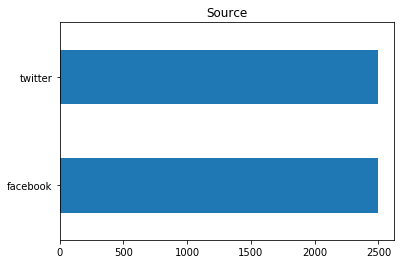

In [6]:
df.source.value_counts().sort_values().plot(kind = 'barh', title="Source")

There are an equal number of Facebook and Twitter posts.

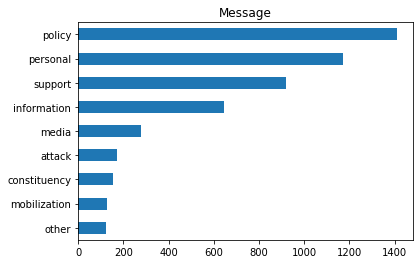

In [7]:
df.message.value_counts().sort_values().plot(kind = 'barh', title="Message")

Most of the posts were tagged as either policy-related or personal. The least common message categories are constituency and mobilization.

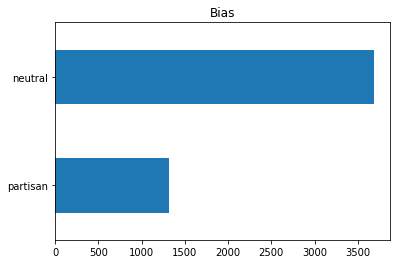

In [8]:
df.bias.value_counts().sort_values().plot(kind = 'barh', title="Bias")

The bias column is heavily imbalanced, with nearly 3 times as many neutral posts as partisan posts. This will need to be accounted for when building a classifier.

Let's isolate the neutral and partisan posts, and print some examples of posts from each category.

In [9]:
neutral_posts = df.text[df.bias == 'neutral']
partisan_posts = df.text[df.bias == 'partisan']

In [10]:
for post in neutral_posts[0:5]:
    print(post)

Please join me today in remembering our fallen heroes and honoring the men and women currently in military service for their sacrifices.
RT @SenatorLeahy: 1st step toward Senate debate on Leahy-Crapo #VAWA bill is the SenateÛªs procedural vote today at 5:30 pm
@BBCWorld, help us keep the kidnapped Nigerian school girls' story out front. #BringBackOurGirls #JoinRepWilson http://t.co/ZqZVT80mga
Show your Arizona pride-choose your favorite S. AZ picture for my Facebook cover photo! Retweet to spread the word! https://t.co/7PHHigA8nd
What a wonderful night at State Senator Ken YagerÛªs Chili Supper benefitting the Boys &amp; Girls Clubs of Roane County. http://t.co/DsyoAFZvkR


From this small subsample of neutral posts, we can gather that posts that express non-political views, or views with bipartisan support, were tagged as neutral.

In [11]:
for post in partisan_posts[0:5]:
    print(post)

RT @nowthisnews: Rep. Trey Radel (R- #FL) slams #Obamacare. #politics https://t.co/zvywMG8yIH
VIDEO - #Obamacare:  Full of Higher Costs and Broken Promises: http://t.co/dn3vzqIrWF
.@amazon delivery #drones show need to update law to promote #innovation &amp; protect #privacy. My #UAS bill does that: http://t.co/l9ta5SKq6u
Called on the @USDOTFRA to release info about inspections before the #CasseltonDerailment to review quality of rails. (1/2)
Great op-ed by Pres. Clinton about signing #FMLA 20 yrs ago today, an important law protecting workers http://t.co/csYEv7O4 #HoyerHeadlines


Conversely, posts tagged as partisan appear to express support for specific policy and legislative issues. To better understand what types of posts were tagged as neutral and partisan, we can plot the value counts for the bias column each of the unique message types:

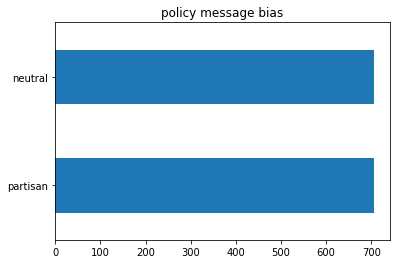

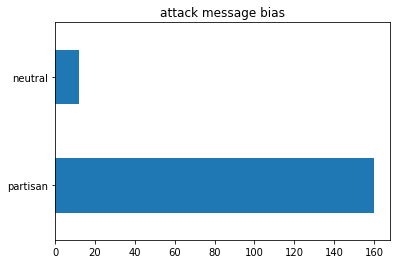

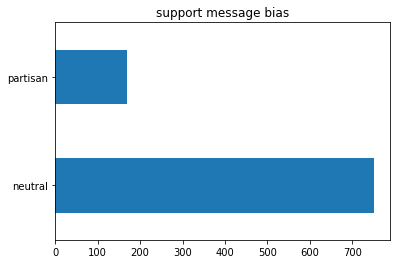

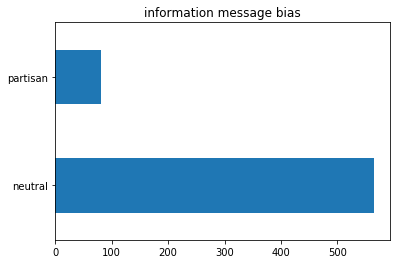

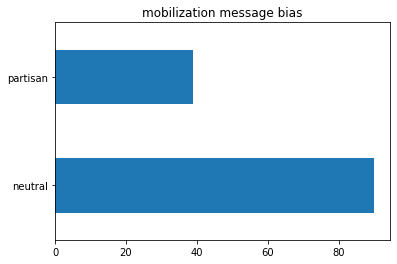

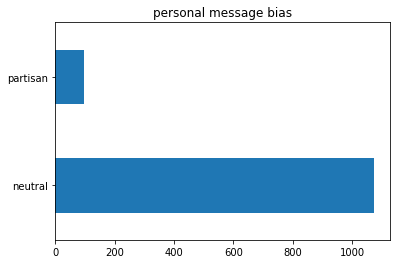

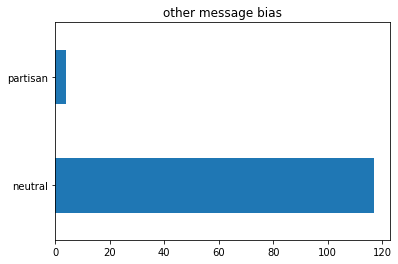

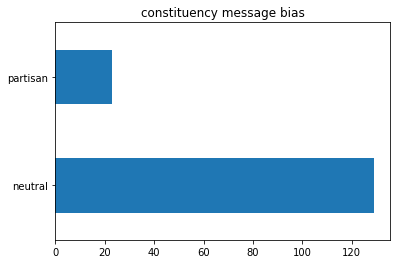

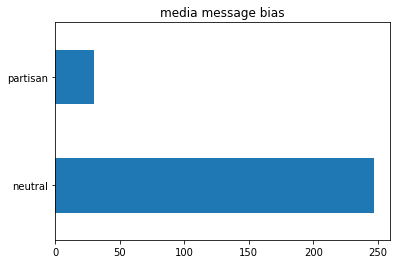

In [12]:
for message in df.message.unique():
    bias = df.bias[df.message==message]
    bias.value_counts().plot(kind = 'barh', title="{} message bias".format(message))
    plt.show()

We can see that for every message category, with the exception of "attack" and "policy", the majority of posts were tagged as neutral.

## Word Frequency

Next, let's visualize the frequency of words and word pairs for neutral and partisan posts. We'll first use the function below to clean the text in the posts. 

In [13]:
stopwords_list = [stopwords.words('english')]
for w in ['http ', 'com', 'amp']:
    stopwords_list.append(w)

In [14]:
def clean_words(text):
    
    """Takes in a string or iterable of strings, and returns a cleaned list of words in the text that was
       passed in."""
    
    #join all strings in text and separate them by white space
    joined_text = "".join(text) 
    
    #remove all characters that are not letters
    joined_text = re.sub('[^A-Za-z ]+', ' ', joined_text)
    
    #convert all words in list to their base form, or 'lemma'
    words = [WordNetLemmatizer().lemmatize(word) for word in joined_text]
    
    #create a list of individual strings for each word in the text 
    words = word_tokenize(joined_text)
    
    #convert all words in list to their base form, or 'lemma'
    words = [WordNetLemmatizer().lemmatize(word) for word in words]
    
    clean_words_list = []
    
    for word in words:
        
        #exclude words that don't contribute to the meaning of the text
        stopwords_list = stopwords.words('english')
        for w in ['http', 'com', 'amp', 'www']:
            stopwords_list.append(w)
        
        if len(word) > 2 and word not in stopwords_list:
            
            #populate clean words list with remaining words
            clean_words_list.append(word.lower())
    
    return clean_words_list

We'll create a clean word list for the partisan and neutral posts.

In [15]:
clean_partisan = clean_words(partisan_posts)
clean_neutral = clean_words(neutral_posts)

NLTK's FreqDist allows us to easily create a frequency distribution for words in the text that's passed in. Below, we create frequency distributions for both classes and display the top 40 words on a line plot. 

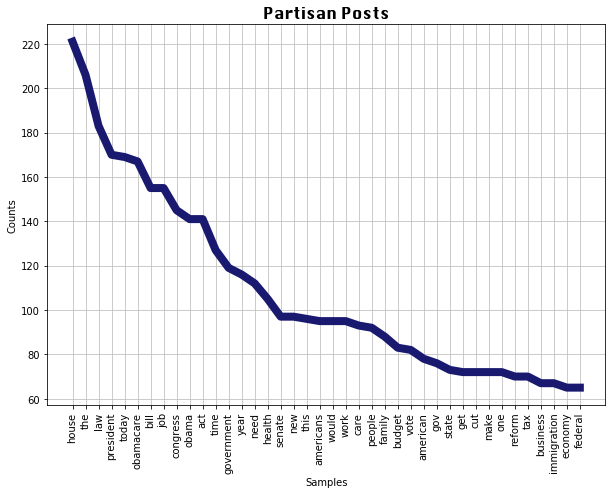

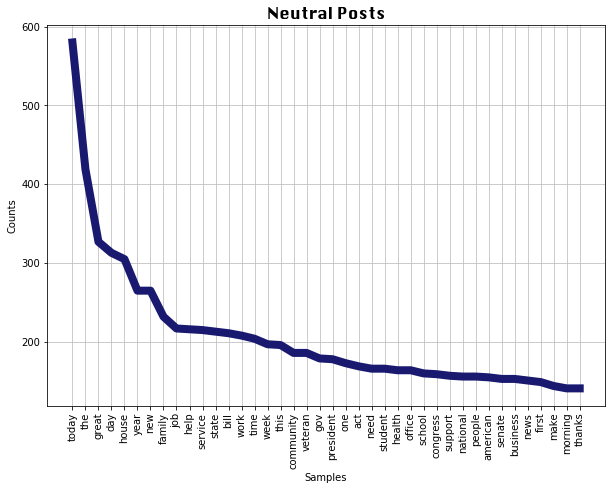

In [16]:
partisan_freqdist = FreqDist(clean_partisan)
Neutral_freqdist = FreqDist(clean_neutral)

plt.figure(figsize=(10, 7))
plt.title('Partisan Posts', fontsize=16, fontname='silom')
partisan_freqdist.plot(40, linewidth=8, color='midnightblue') 

plt.figure(figsize=(10, 7))
plt.title('Neutral Posts', fontsize=16, fontname='silom')
Neutral_freqdist.plot(40, linewidth=8, color='midnightblue');

### Wordclouds

Word clouds are another way to visualize word frequency: given a number for the top most frequent words, they display various words in a text with larger font for more frequent words.

In [17]:
def plot_wordcloud(clean_words, name):
     
    """Takes in a clean list of words and a name for the word cloud. Returns a 25x25 word cloud 
    with the top 1000 most frequent words."""
        
    wc = WordCloud(background_color="Black", max_words=1000, max_font_size = 50)
    clean_string = ','.join(clean_words)
    wc.generate(clean_string)

    f = plt.figure(figsize=(25,25))
    plt.axis("off")
    plt.imshow(wc, interpolation='bilinear')
    plt.title('{} Word Cloud'.format(name), size=30, fontname='Silom')
    plt.axis("off")
    plt.show()

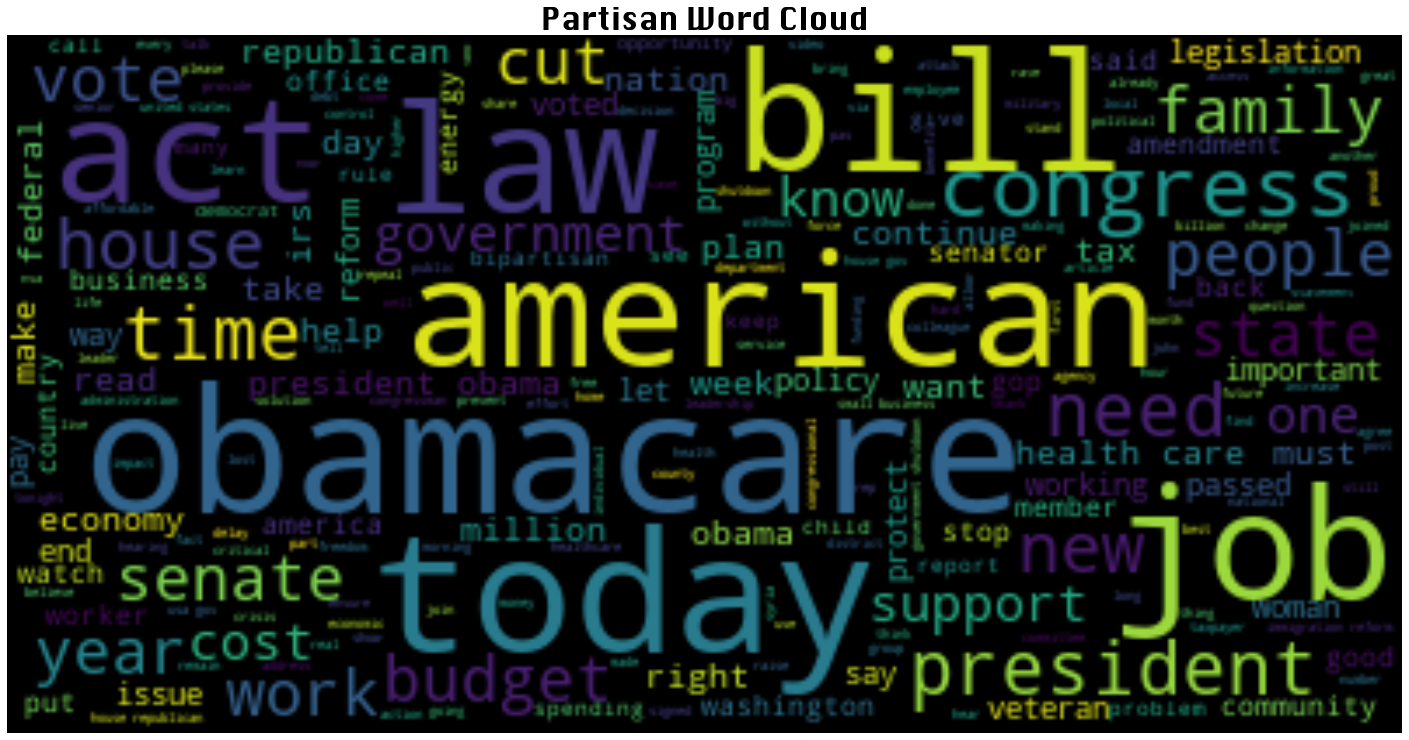

In [18]:
plot_wordcloud(clean_partisan, "Partisan")

'Obamacare', 'bill', and 'law' stand out as some of the most prominent words.

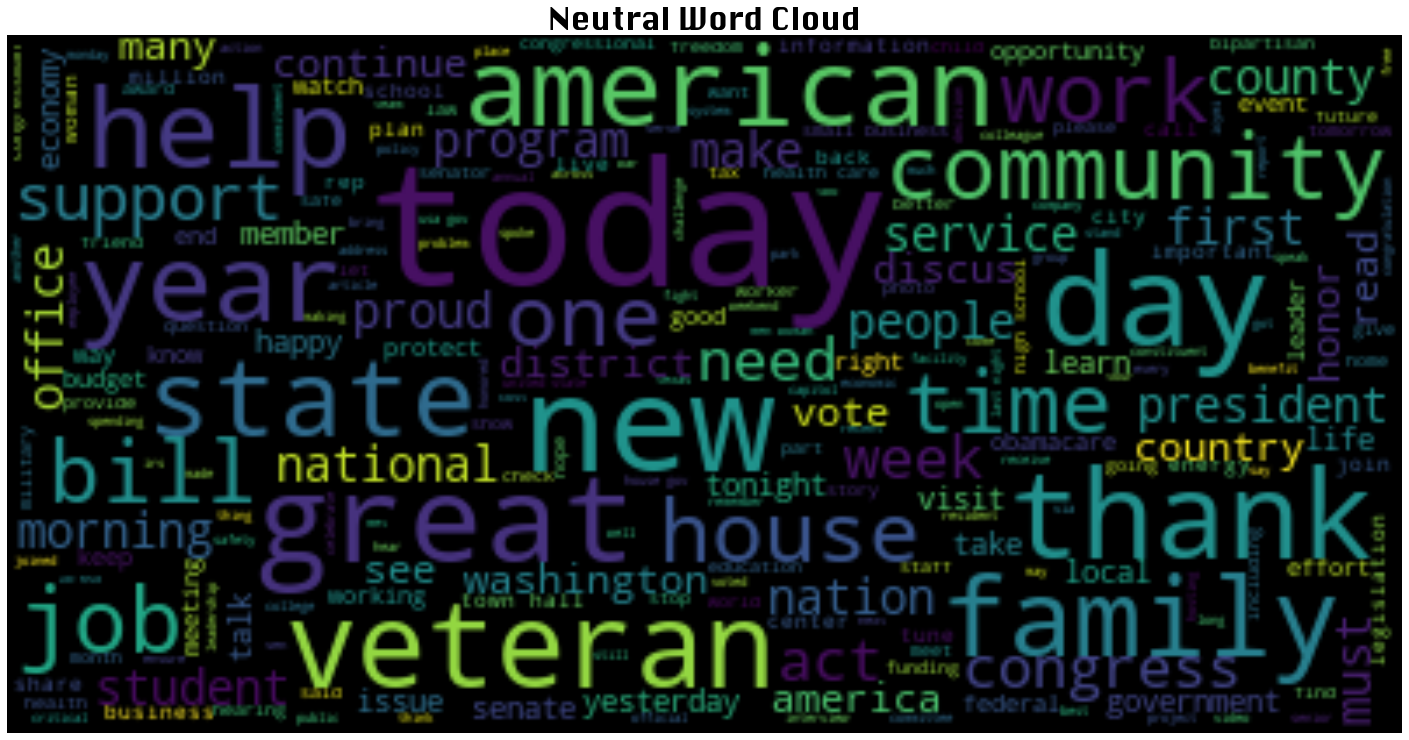

In [19]:
plot_wordcloud(clean_neutral, "Neutral")

'Today', 'veteran', and 'american' are a few of the prominent words in the neutral post subset.

### Bigrams

Now let's examine some of the most common word pairings, or bigrams. The following function will plot these pairings in an easy-to-interpret horizontal bar plot.

In [20]:
def plot_bigrams(clean_data, data_name):
    
    """Takes in a clean list of words and a name for the Bigram plot. Returns a 10x7 bigram barplot 
       with the top 20 most frequent words."""
    
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(clean_data)
    scored = finder.score_ngrams(bigram_measures.raw_freq)
    
    bigrams = []
    freqs = []

    
    for bigram in scored[:20]:
        bigrams.append(str(bigram[0]))
        freqs.append(bigram[1])
        
    plt.figure(figsize=(10, 7))
    plt.title("{} Bigrams".format(data_name), fontname='silom', fontsize=15)
    plt.barh(bigrams, freqs, color='midnightblue')

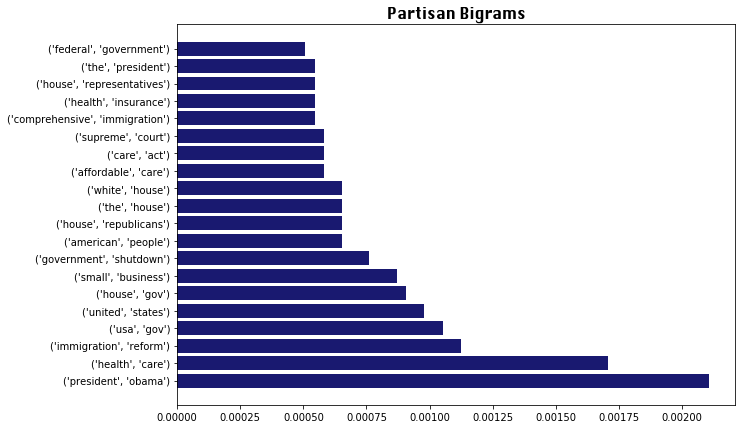

In [21]:
plot_bigrams(clean_partisan, 'Partisan')

'President Obama', 'health care' and 'immigration reform' are among the most common partisan bigrams.

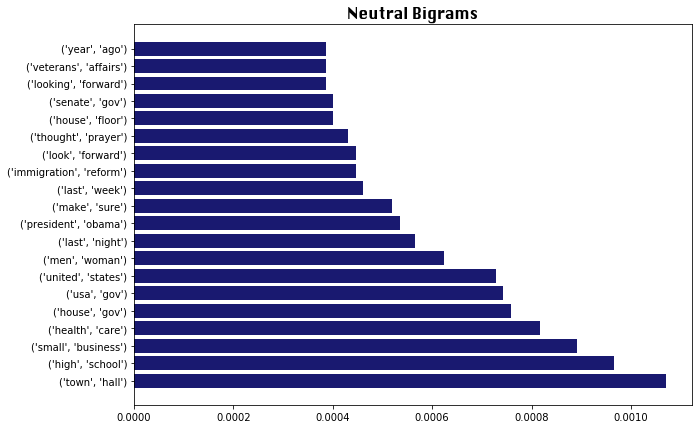

In [22]:
plot_bigrams(clean_neutral, 'Neutral')

Common neutral bigrams include 'town hall', 'high school', and 'small business'.

# Classifying Partisan Bias

To build a bias classifier, let's begin by defining x and y. We'll clean each row in the text column and append them to a new list, X:

In [23]:
posts = []

for row in df.text:
    posts.append(clean_words(row))
    
clean_posts = [" ".join(post) for post in posts]
clean_posts[0:5]

['nowthisnews rep trey radel slam obamacare politics zvywmg yih',
 'video obamacare full higher costs broken promises vzqirwf',
 'please join today remembering fallen hero honoring men woman currently military service sacrifice',
 'senatorleahy step toward senate debate leahy crapo vawa bill senate procedural vote today',
 'amazon delivery drone show need update law promote innovation protect privacy uas bill doe skq']

To convert the posts to numeric data, we'll use <b>Latent Semantic Analysis (LSA)</b> from the [NLP Primitives](https://pypi.org/project/nlp-primitives/) library. Using TF-IDF and singular value decomposition, LSA converts each string into two numeric values, as shown below. TF-IDF is a product of the following weights: 

* <b> Term Frequency: </b> Number of times a word appears in a document/total number of words in a document
* <b> Inverse Document Frequency: </b> log of total number of documents/number of documents that contain the word

In our case, a document is a social media post within the larger collection of posts in the 'text' column.

In [24]:
lsa = LSA()
X = pd.DataFrame(lsa(clean_posts).tolist()).T
X.head()

,0,1
0,0.000236,-0.000037
1,0.007594,0.001050
2,0.011779,0.001309
3,0.002466,0.000042
4,0.004215,0.003062


To numerically encode y, we'll get dummy variables for the 'bias' column and drop the neutral column. In the remaining column, 1=partisan and 0=neutral.

In [25]:
y = pd.get_dummies(df.bias).drop('neutral', axis=1).values.ravel()

In [26]:
display(X, y)

,0,1
0,0.000236,-0.000037
1,0.007594,0.001050
2,0.011779,0.001309
3,0.002466,0.000042
4,0.004215,0.003062
...,...,...
4995,0.010788,-0.001745
4996,0.009812,0.001960
4997,0.021712,0.017755
4998,0.014022,0.012812


array([1, 1, 0, ..., 0, 0, 0], dtype=uint8)

Above, we can see that both x and y have been converted to arrays of numeric data. We can now split the data into training a test sets:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

## Random Forest

Our first model will be a <b> random forest </b> classifier. We'll pass the parameter grid below into ```RandomizedSearchCV``` to choose the best parameters for the model. Note that the 'class weight' options are both balanced, which should correct some of the class imbalance in y.

In [28]:
class_weight = ['balanced', 'balanced_subsample']
n_estimators = [50, 100, 150, 500, 1000]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 80, 100, 120]
min_samples_split = [2, 5, 6, 7, 10]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]
param_grid = {'class_weight' : class_weight,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [29]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, 
                               n_iter = 10, cv = 5, random_state=6, n_jobs = -1)

In [30]:
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 50, 80, 100, 120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 6, 7, 10],
                                        'n_estimators': [50, 100, 150, 500,
                                                         1000]},
                   random_state=6)

We can retrieve the best-performing parameters from the search with the ```best_params_``` attribute.

In [31]:
best_params = rf_random.best_params_
best_params

{'n_estimators': 500,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'class_weight': 'balanced',
 'bootstrap': True}

Below, we fit the best model to the training data.

In [32]:
optimized_rf = rf_random.best_estimator_
optimized_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_split=7, n_estimators=500)

The below function will allow us to easily evaluate the model's performance on both the training and test data. It plots a confusion matrix for each, as well as performance scores.

In [33]:
def plot_cm(model, model_type, X_test, y_test, X_train, y_train, class_names):
    
    """Takes in a fitted classifier, a string for the the model type, 
       X and y training and test data, and a list of the class names. Returns a 7x5 
       confusion matrix for training and test data, with accuracy, precision, recall 
       and F1 scores plotted next to the matrices."""
    
    y_preds = model.predict(X_test)
    class_names = class_names
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Reds, ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Test Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_test, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_test, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_test, y_preds), 3))),fontsize=14)
    
    plt.show()
    
    y_preds = model.predict(X_train)
    class_names = class_names
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_confusion_matrix(model, X_train, y_train,
                                 display_labels=class_names,
                                 cmap=plt.cm.Reds, ax=ax)
    plt.text(x=-.5, y=-.6, s="{} Training Confusion Matrix".format(model_type), fontsize=15, fontname='silom')
    plt.text(x=2.1, y=.1, s="Accuracy: {}".format(float(round(accuracy_score(y_train, y_preds),3))), fontsize=14)
    plt.text(x=2.1, y=.3, s="Precision: {}".format(float(round(precision_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.5, s="Recall: {}".format(float(round(recall_score(y_train, y_preds), 3))),fontsize=14)
    plt.text(x=2.1, y=.7, s="F1: {}".format(float(round(f1_score(y_train, y_preds), 3))),fontsize=14)
    
    plt.show()

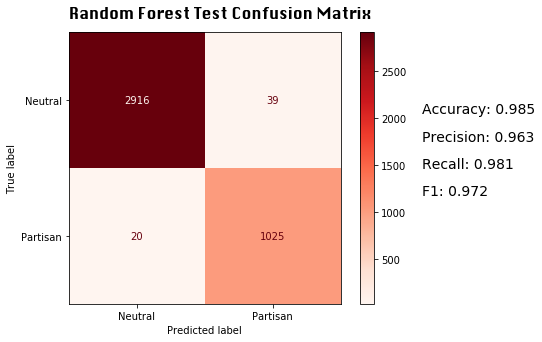

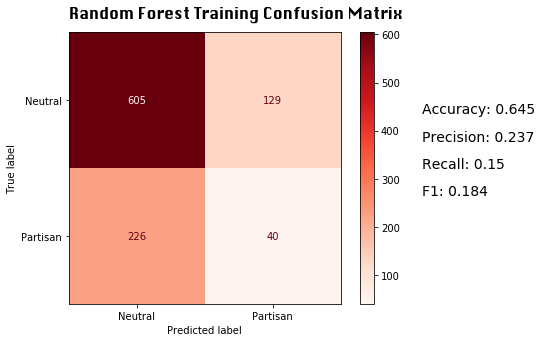

In [34]:
plot_cm(optimized_rf, 'Random Forest',
        X_train, y_train, 
        X_test, y_test, 
        class_names=['Neutral', 'Partisan'])

The model performs well on the test data, but fails on the training data. The model predicted that 221 partisan posts in the training data were neutral. This issue can be corrected by over-sampling the minority class (partisan posts) with the <b>Synthetic Minority Oversampling Technique (SMOTE)</b> . 

In [35]:
smote = SMOTE(random_state=6)
X, y = smote.fit_resample(X, y)

If we look at the value counts in y, we can see that there are now an equal number of '0'(neutral) and '1'(partisan') values:

In [36]:
counter = Counter(y)
print(counter)

Counter({1: 3689, 0: 3689})


Below, we create new training and test subsets from the resampled data, and fit the random forest model to the data.

In [37]:
SMOTE_X_train, SMOTE_X_test, SMOTE_y_train, SMOTE_y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

In [38]:
optimized_rf.fit(SMOTE_X_train, SMOTE_y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100,
                       min_samples_split=7, n_estimators=500)

In [39]:
SMOTE_y_test

array([0, 1, 0, ..., 1, 0, 1], dtype=uint8)

In [40]:
joblib.dump(optimized_rf, "./random_forest.joblib")

['./random_forest.joblib']

Let's see how the model performs on the original training and test data:

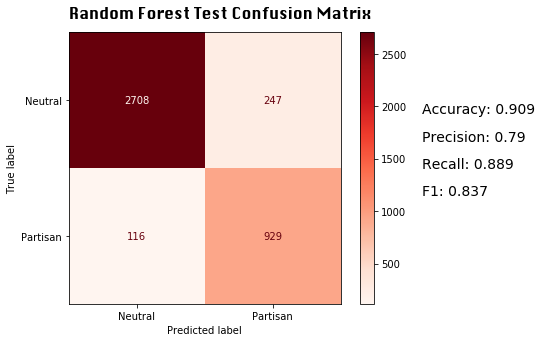

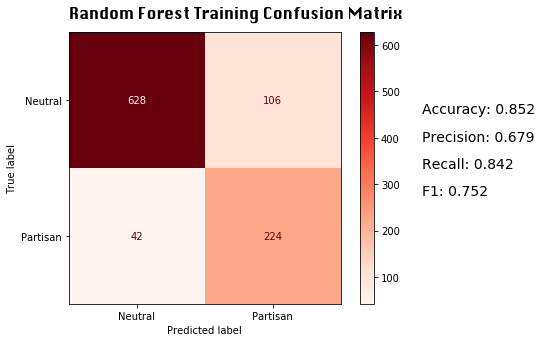

In [41]:
plot_cm(optimized_rf, 'Random Forest',
        X_train, y_train, 
        X_test, y_test, 
        class_names=['Neutral', 'Partisan'])

The model's performance on the training data improved significantly after over-sampling the minority class: the new accuracy score is .85. Performance on the test data also improved, with a .90 accuracy score.

# Classifying the Message of Posts

We'll define X again, and use <b>LabelEncoder</b> to convert values in the message column to integers:

In [47]:
lsa = LSA()
X = pd.DataFrame(lsa(clean_posts).tolist()).T

In [48]:
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(df.message)).values.ravel()

We can access the classes that have been encoded by using ```classes_```:

In [49]:
le.classes_

array(['attack', 'constituency', 'information', 'media', 'mobilization',
       'other', 'personal', 'policy', 'support'], dtype=object)

The first class, 'attack', in this array has been encoded as 0, 'constituency' has been encoded as 1, and so on. Below, we can see how the labels have been encoded for the first 10 posts in the data.

In [50]:
list(zip(df.message.head(10), y[0:10]))

[('policy', 7),
 ('attack', 0),
 ('support', 8),
 ('policy', 7),
 ('policy', 7),
 ('information', 2),
 ('mobilization', 4),
 ('mobilization', 4),
 ('personal', 6),
 ('support', 8)]

## K-Nearest Neighbors

We'll create a <b> K-Nearest Neighbors (KNN)</b> model to predict the posts' message. Since the message column also has highly imbalanced classes, we'll resample the data again using SMOTE, and split it into training and test sets:

In [51]:
X, y = smote.fit_resample(X, y)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9)

KNN is an algorithm that makes predictions based on the distance between a value in X and other X-values. It assumes that highly proximate values will be members of the same class. We'll tune the following parameters:

* <b>N-Neighbors:</b> Number of neighbors (close values) 
* <b>p:</b> distance metric (Euclidean vs. Manhattan)

In [53]:
n_neighbors = [1, 2, 3, 5, 10, 15]
p=[1,2]

param_grid = {'n_neighbors': n_neighbors, 
              'p': p}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=4)

In [54]:
knn_optimized = knn_grid.fit(X_train, y_train)

In [55]:
knn_grid.best_params_

{'n_neighbors': 1, 'p': 2}

In [56]:
y_train_preds = knn_optimized.predict(X_train)
accuracy_score(y_train_preds, y_train)

0.9971453883256226

The model had a near-perfect accuracy score for the training data, which may suggest overfitting.

In [57]:
y_test_preds = knn_optimized.predict(X_test)
accuracy_score(y_test_preds, y_test)

0.4547244094488189

The accuracy score on the training data was .45. This is not exceptional, but given the relatively large number of classes (9), it's also not terrible. In a dataset with balanced classes, there would be about a .11 accuracy rate with random guessing. Let's plot a confusion matrix to see how the test predictions compare to the true test labels.

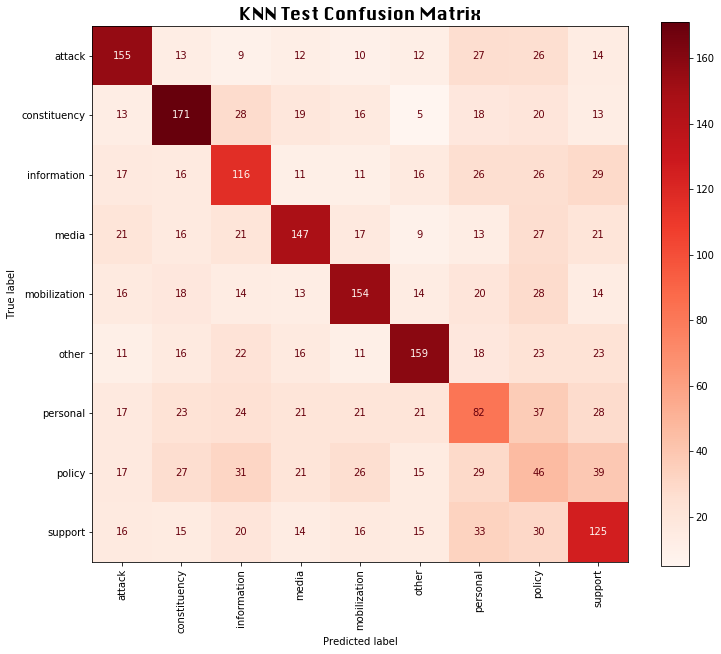

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_confusion_matrix(knn_optimized, X_test, y_test,
                                display_labels=list(le.classes_),
                                cmap=plt.cm.Reds, xticks_rotation='vertical', ax=ax)
plt.title('KNN Test Confusion Matrix', fontname='silom', fontsize=17)
plt.show()

For all classes, the highest number of predicted labels matched the true label. 

# Making Predictions on New Data

### Retrieving the Tweets

Using Twitter's API and Tweepy, we can generate a new sample of Tweets from politicians. The function below retrieves up to 30 recent Tweets and returns them as a list of strings. 

<b>Note:</b> for the below code to work properly in reproduction, a unique consumer key and secret will need to be passed into the "auth" object. Tweepy's [Authentication Tutorial](http://docs.tweepy.org/en/latest/auth_tutorial.html) may be consulted for futher details.

In [60]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)

In [100]:
def get_30_tweets(username): 
    
    """Takes in a Twitter username. Returns up to 30 Tweets after Twitter api is defined as 'api'."""
    
    tweets = api.user_timeline(screen_name=username, count=30, tweet_mode="extended", lang="en")
    
    tweets_list = []
    
    tweets = [tweet.full_text for tweet in tweets]
    
    for tweet in tweets:
        if not tweet[:1].startswith("@") and 'https' not in tweet:
            tweets_list.append(tweet)
            
    return tweets_list

Let's get Tweets from the accounts of two politicians who are on many Americans' minds this election season: Donald Trump and Joe Biden.

In [62]:
DT_Tweets = get_30_tweets('POTUS')

In [67]:
JB_Tweets = get_30_tweets('JoeBiden')

### Predictions Example: Joe Biden

We'll process the Joe Biden Tweets in the same way as the posts from the original dataframe:

In [68]:
JB_clean = []

for tweet in JB_Tweets:
    JB_clean.append(clean_words(tweet))

In [69]:
JB_clean = [" ".join(post) for post in JB_clean]

In [70]:
lsa = LSA()
JB_lsa = pd.DataFrame(lsa(JB_clean).tolist()).T

message_preds = knn_optimized.predict(JB_lsa)
bias_preds = optimized_rf.predict(JB_lsa)

Let's look at the order of the encoded classes again:

In [71]:
le.classes_

array(['attack', 'constituency', 'information', 'media', 'mobilization',
       'other', 'personal', 'policy', 'support'], dtype=object)

Now let's isolate the predicted partisan Tweets and print them:

In [74]:
JB_df = pd.DataFrame({'Tweet': JB_Tweets, 'Partisan Bias': bias_preds, 'Message': message_preds})

In [75]:
print('Joe Biden Partisan Tweets:')
print('')
for i in JB_df[JB_df['Partisan Bias'] == 1].Tweet: #Tweet rows in JB_df where Partisan Bias = 1 (partisan)
    print(i)

Joe Biden Partisan Tweets:

Jill and I are keeping the French people in our prayers following the horrific terror attack in Nice — which targeted innocents in a house of worship. A Biden-Harris administration will work with our allies and partners to prevent extremist violence in all forms.
GDP rose last quarter, but visits to food banks haven’t slowed, and poverty has grown. We’re on track for the worst economic downturn in over 70 years, and Donald Trump is on track to be the first president since Herbert Hoover to leave office with less jobs than when he came in.


The question of whether this prediction is accurate is open to interpretation, but language such as 'horrific', 'extremist', and 'worst economic downturn' is arguably non-neutral. How many Tweets did the model classify as neutral?

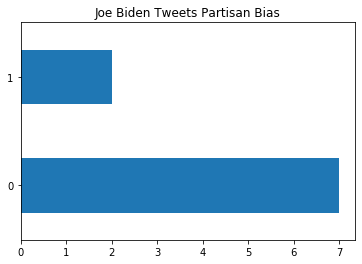

In [76]:
bias = JB_df['Partisan Bias']
bias.value_counts().plot(kind = 'barh', title="Joe Biden Tweets Partisan Bias")
plt.show()

7/9 Tweets were classified as neutral. To test the message classification model, let's print the Tweets that were classified as personal.

In [77]:
print('Joe Biden Personal Tweets:')
print('')
for i in JB_df[JB_df['Message'] == 6].Tweet: #Tweet rows in JB_df where Message = 6 (personal)
    print(i)

Joe Biden Personal Tweets:

Now more than ever, we need a president who will choose compassion over cruelty.


While this message is not explicitly an attack, the implicit message is that the current president has not been compassionate in his leadership. It is not about Joe Biden's personal life, but it also contains the implicit statement that Biden would personally "choose compassion over cruelty" if elected president. The accurate label for this post is similarly subject to debate. What is the distribution of the predicted message classes?

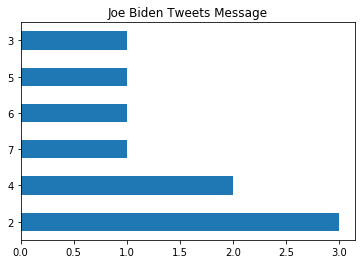

In [78]:
bias = JB_df['Message']
bias.value_counts().plot(kind = 'barh', title="Joe Biden Tweets Message")
plt.show()

The predicted message classes for Joe Biden's Tweets include information, 'other', and personal Tweets, with constituency Tweets being the most common.

### Predictions Example: Donald Trump

As above, we'll preprocess the data:

In [79]:
DT_clean = []

for tweet in DT_Tweets:
    DT_clean.append(clean_words(tweet))

In [80]:
DT_clean = [" ".join(post) for post in DT_clean]

In [81]:
lsa = LSA()
DT_df = pd.DataFrame(lsa(DT_clean).tolist()).T
bias_preds = optimized_rf.predict(DT_df)
message_preds = knn_optimized.predict(DT_df)

In [82]:
DT_df = pd.DataFrame({'Tweet': DT_Tweets, 'Partisan Bias': bias_preds, 'Message': message_preds})

Which Tweets were labeled as partisan?

In [94]:
print('Donald Trump Partisan Tweets:')
print('')
for i in DT_df[DT_df['Partisan Bias'] == 1].Tweet:
    print(i)

Donald Trump Partisan Tweets:

RT @realDonaldTrump: On the 37th anniversary of the horrendous attack on our United States Marines, Sailors, and Soldiers in Beirut, we hon…
RT @realDonaldTrump: Judiciary Committee approves Judge Barrett. Moves to full Senate for final vote. Big day for America!
RT @realDonaldTrump: ....Should take care of our people. It wasn’t their fault that the Plague came in from China!
RT @realDonaldTrump: Just don’t see any way Nancy Pelosi and Cryin’ Chuck Schumer will be willing to do what is right for our great America…
RT @realDonaldTrump: Will be interviewed on @foxandfriends at 8:00 A.M. Enjoy!
RT @realDonaldTrump: ....Washington wants nothing to do with him, and that’s so bad for New York, which has become a ghost town. Andrew spe…
RT @realDonaldTrump: Will be interviewed by @Varneyco on @FoxBusiness  at 10:00 A.M.  Enjoy!


All of these Tweets, perhaps with the exception of the interview announcements, use non-neutral language and are argubly expressing partisan views. Let's check the neutral Tweet count:

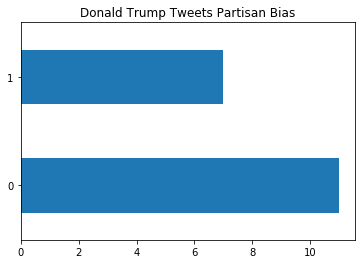

In [84]:
bias = DT_df['Partisan Bias']
bias.value_counts().plot(kind = 'barh', title="Donald Trump Tweets Partisan Bias")
plt.show()

The majority (11/18) of Tweets were labeled as neutral. Were any Tweets labeled as information?

In [99]:
print('Donald Trump Information Tweets:')
print('')
for i in DT_df[DT_df['Message'] == 1].Tweet:
    print(i)

Donald Trump Information Tweets:

RT @IvankaTrump: Yesterday @realDonaldTrump granted Duke Tanner clemency after 16 years in prison.

Duke was sentenced to life in prison fo…
RT @realDonaldTrump: Judiciary Committee approves Judge Barrett. Moves to full Senate for final vote. Big day for America!


Each of these two Tweets contain at least one informative statement. The second statement of the second Tweet contains the non-neutral word 'great', which suggests it could have been classified as 'support' instead. What other classes were predicted?

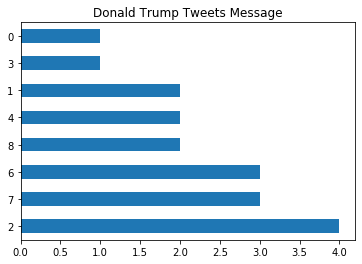

In [86]:
bias = DT_df['Message']
bias.value_counts().plot(kind = 'barh', title="Donald Trump Tweets Message")
plt.show()

As with Joe Biden's Tweets, the majority class is information (numeric label=2).

# Conclusions and Recommendations

The Random Forest model can be used to predict whether a social media post is partisan or neutral with high accuracy. After collecting Tweets or other social media posts for more recent data, partisan posts can be identified and extracted for review by constituents or organizations interested in learning more about a particular politician's views. 

The KNN model can classify the message of a post with higher accuracy than random guessing, and performs particularly well on posts that address a politician's constituency. This model can be used to identify such posts for constituents and organizations that engage them. 

The exploratory analysis suggested that posts perceived as partisan tend to contain words related to specific policy or legislative issues, like "bill", "law", "health care," and "immigration reform." These terms can be used in queries when attempting to collect partisan posts. 

Future work should test and optimize different model types, particularly for the message classification task. It may also be fruitful to collect and label more recent data of a similar type, and assess how the distribution of classes has changed since 2015.

# References

[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

[NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html?highlight=nearest%20neighbors#sklearn.neighbors.NearestNeighbors)

[nlp_primitives.LSA](https://docs.featuretools.com/en/v0.12.0/generated/nlp_primitives.LSA.html#nlp_primitives.LSA)

[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[Tweepy](http://docs.tweepy.org/en/latest/)
